## Building Seq2Seq RNN in tf from scratch

tutorial taken from: https://medium.com/@erikhallstrm/hello-world-rnn-83cd7105b767  
working with __tf.\_\_version\_\___=1.2.1; __np.\_\_version\_\___=1.14.2

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import Image

%matplotlib inline

In [2]:
tf.__version__

'1.2.1'

### Params

In [3]:
num_epochs = 100
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3 # shift between x and y
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length; print("num_batches:", num_batches)

num_batches: 666


- __num_epochs__: num_epochs
- __total_series_length__: full len of the original sequence
- __truncated_backprop_length__: number of rnn previous steps to roll-back in BPTT (?)
- __state_size__: inner state vector size
- __num_classes__: binary i/o sequences
- __echo_step__: the shift between x and y sequences
- __batch_size__: batch_size
- __num_batches__: num_batches

### Generate Data

we generate data as:
- __x__: a random binary (0/1) sequence of length __total_series_length__
- __y__: we shift x by __echo_step__ indices (shift with rotation: i.e., last elements that are ommited will be added at the beginning of they sequence by the np.roll function)

In [4]:
# # for clear understanding of generateData, run this cell:
# x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))

# print(pd.Series(x).value_counts())

# y = np.roll(x, echo_step)
# y[0:echo_step] = 0

# print(x[:10])
# print(y[1:11])
# print(y[:10])

In [5]:
def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)

In [6]:
x, y = generateData()
x.shape, y.shape

((5, 10000), (5, 10000))

In [7]:
# Image(filename="rnn_to_batches.png")

### Build Graph

#### Placeholders

In [8]:
with tf.name_scope(name="input") as scope:
    batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length], name="batchX_placeholder")
    batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length], name="batchY_placeholder")

    init_state = tf.placeholder(tf.float32, [batch_size, state_size], name="init_state")

In [9]:
print("batchX_placeholder (batch-size, truncated_backprop_length):\n", batchX_placeholder)
print("\nbatchY_placeholder (batch-size, truncated_backprop_length):", batchY_placeholder)
print("\ninit_state (batch-size, inner-state-dim):\n", init_state)

batchX_placeholder (batch-size, truncated_backprop_length):
 Tensor("input/batchX_placeholder:0", shape=(5, 15), dtype=float32)

batchY_placeholder (batch-size, truncated_backprop_length): Tensor("input/batchY_placeholder:0", shape=(5, 15), dtype=int32)

init_state (batch-size, inner-state-dim):
 Tensor("input/init_state:0", shape=(5, 4), dtype=float32)


#### Variables

In [10]:
with tf.name_scope(name="weights") as scope:
    W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32, name="W")
    b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32, name="b")

    W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32, name="W2")
    b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32, name="b2")

In [11]:
print("W:", W)
print("b:", b)
print("W2:", W2)
print("b2:", b2)

# the next cell's state = 

W: <tf.Variable 'weights/W:0' shape=(5, 4) dtype=float32_ref>
b: <tf.Variable 'weights/b:0' shape=(1, 4) dtype=float32_ref>
W2: <tf.Variable 'weights/W2:0' shape=(4, 2) dtype=float32_ref>
b2: <tf.Variable 'weights/b2:0' shape=(1, 2) dtype=float32_ref>


In [12]:
# Unpack columns
inputs_series = tf.unstack(batchX_placeholder, axis=1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

In [13]:
inputs_series

[<tf.Tensor 'unstack:0' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:1' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:2' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:3' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:4' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:5' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:6' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:7' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:8' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:9' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:10' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:11' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:12' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:13' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:14' shape=(5,) dtype=float32>]

In [14]:
# truncated_backprop_length = 15
# batch_size = 5


In [15]:
# Forward pass
current_state = init_state
states_series = []
for current_input in inputs_series:
    current_input = tf.reshape(current_input, [batch_size, 1])
    input_and_state_concatenated = tf.concat([current_input, current_state], 1)  # Increasing number of columns

    next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)  # Broadcasted addition
    states_series.append(next_state)
    current_state = next_state

In [16]:
logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits, labels in zip(logits_series,labels_series)]
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

In [17]:
def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


New data, epoch 0
Step 0 Loss 0.6847934
Step 100 Loss 0.6972129
Step 200 Loss 0.6942623
Step 300 Loss 0.6950863
Step 400 Loss 0.7110847
Step 500 Loss 0.69448143
Step 600 Loss 0.69089353
New data, epoch 1
Step 0 Loss 0.6839839
Step 100 Loss 0.6912661
Step 200 Loss 0.69127256
Step 300 Loss 0.707961
Step 400 Loss 0.11686807
Step 500 Loss 0.041222695
Step 600 Loss 0.01945465
New data, epoch 2
Step 0 Loss 0.16639635
Step 100 Loss 0.011587953
Step 200 Loss 0.015268763
Step 300 Loss 0.007567437
Step 400 Loss 0.0065148515
Step 500 Loss 0.008075651
Step 600 Loss 0.003912331
New data, epoch 3
Step 0 Loss 0.20713136
Step 100 Loss 0.005337105
Step 200 Loss 0.002170749
Step 300 Loss 0.0030984099
Step 400 Loss 0.004019403
Step 500 Loss 0.0020313135
Step 600 Loss 0.0021611315
New data, epoch 4
Step 0 Loss 0.24363515
Step 100 Loss 0.0021893312
Step 200 Loss 0.0019544617
Step 300 Loss 0.0019766502
Step 400 Loss 0.0028366111
Step 500 Loss 0.0010591608
Step 600 Loss 0.0017750072
New data, epoch 5
Step 0 

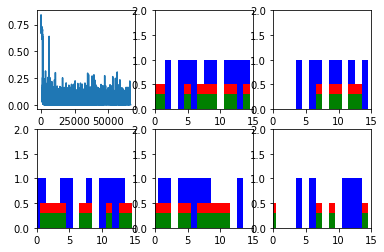

In [18]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        x,y = generateData()
        _current_state = np.zeros((batch_size, state_size))

        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })

            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)
                
plt.ioff()
plt.show()